In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [10]:
option_exposure = -1  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

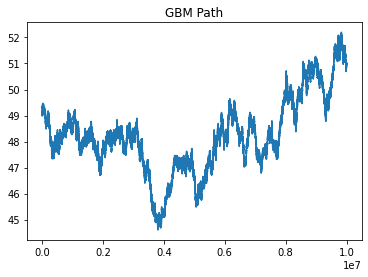

In [11]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
np.random.seed(seed=1234)
M = 100000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [12]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)
option_value_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type)*option_exposure

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


The time of execution of is: 2.490750789642334
Option price is [2.40052732 2.40099984 2.3998058  ... 0.97337959 0.97427275 0.97263108]


In [13]:
summary_df = pd.DataFrame(list(zip(S, option_value_array, delta_array)), columns=['Stock_Price', 'Option_Value', 'Delta'])
summary_df

,Stock_Price,Option_Value,Delta
0,49.000000,-2.400527,0.521605
1,49.000906,-2.401000,0.521664
2,48.998617,-2.399806,0.521514
3,49.001371,-2.401242,0.521694
4,49.000770,-2.400928,0.521655
...,...,...,...
9999995,50.973043,-0.973043,1.000000
9999996,50.972426,-0.972426,1.000000
9999997,50.973379,-0.973380,1.000000
9999998,50.974273,-0.974273,1.000000


In [14]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Share_PnL'] = summary_df['Shares_Held'].shift()*(summary_df['Stock_Price'] - summary_df['Stock_Price'].shift())
summary_df['Option_PnL'] = summary_df['Option_Value'] - summary_df['Option_Value'].shift()
summary_df['Portfolio_PnL'] = summary_df['Option_PnL'] + summary_df['Share_PnL']
summary_df['Portfolio_Value'] = summary_df['Option_Value'] + summary_df['Shares_Held']*summary_df['Stock_Price']
summary_df

,Stock_Price,Option_Value,Delta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Share_PnL,Option_PnL,Portfolio_PnL,Portfolio_Value
0,49.000000,-2.400527,0.521605,0.521605,0.521605,25.558628,25.558628,NaN,NaN,NaN,23.158101
1,49.000906,-2.401000,0.521664,0.521664,0.000059,0.002910,25.561538,0.000473,-0.000473,1.386866e-07,23.161011
2,48.998617,-2.399806,0.521514,0.521514,-0.000150,-0.007351,25.554187,-0.001194,0.001194,-6.119274e-09,23.153660
3,49.001371,-2.401242,0.521694,0.521694,0.000180,0.008843,25.563030,0.001436,-0.001436,-8.288945e-08,23.162503
4,49.000770,-2.400928,0.521655,0.521655,-0.000039,-0.001930,25.561100,-0.000313,0.000314,1.537657e-07,23.160573
...,...,...,...,...,...,...,...,...,...,...,...
9999995,50.973043,-0.973043,1.000000,1.000000,-0.000000,-0.000000,52.033084,0.001149,-0.001149,9.615385e-08,50.000000
9999996,50.972426,-0.972426,1.000000,1.000000,-0.000000,-0.000000,52.033084,-0.000617,0.000617,9.615386e-08,50.000000
9999997,50.973379,-0.973380,1.000000,1.000000,-0.000000,-0.000000,52.033084,0.000954,-0.000954,9.615385e-08,50.000000
9999998,50.974273,-0.974273,1.000000,1.000000,-0.000000,-0.000000,52.033084,0.000893,-0.000893,9.615386e-08,50.000000


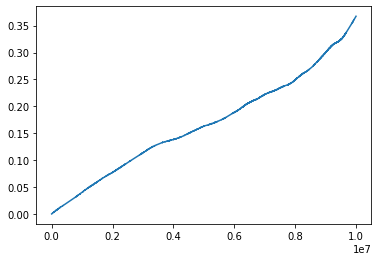

In [15]:
plt.plot(summary_df['Portfolio_PnL'].cumsum())

In [16]:
summary_df['Portfolio_Value'].iloc[0]*np.exp(r*T) - summary_df['Portfolio_Value'].iloc[0]

0.4496578731622769